In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import utils

import gc

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class DQN(nn.Module):

    def __init__(self, c, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(c, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.hidden = nn.Linear(3136, 512, bias=True)
        self.head = nn.Linear(512, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.hidden(x))
        return F.softmax(self.head(x))

In [4]:
env = gym.make('Breakout-v0').unwrapped
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

In [5]:
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 100000
TARGET_UPDATE = 3000
MEMORY_SIZE = 20000
HISTORY_LENGTH = 3
SKIP_FRAMES = 1
CHECKPOINT_UPDATE = 500
CHART_UPDATE = 25

# Get number of actions from gym action space
n_actions = env.action_space.n - 1

policy_net = DQN(HISTORY_LENGTH, n_actions).to(device)
target_net = DQN(HISTORY_LENGTH, n_actions).to(device)

optimizer = optim.RMSprop(policy_net.parameters(), lr=0.00025, eps=0.01, momentum=0.95)

memory = utils.ReplayMemory(MEMORY_SIZE)

gc.collect()
torch.cuda.empty_cache()

steps_done = 0
i_episode = 0
durations = []

frames = deque([], maxlen=HISTORY_LENGTH)

In [6]:
checkpoint_name = "breakout_dqn_v4_23000"

if checkpoint_name:
    extra = utils.load_checkpoint(policy_net, optimizer, checkpoint_name)
    memory = extra["memory"]
    steps_done = extra["steps_done"]
    i_episode = extra["i_episode"]
    durations = extra["durations"]

INFO: Checkpoint breakout_dqn_v4_23000 loaded!


In [7]:
policy_net = policy_net.to(device)
target_net = target_net.to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden): Linear(in_features=3136, out_features=512, bias=True)
  (head): Linear(in_features=512, out_features=3, bias=True)
)

In [8]:
def optimize_model(policy_net, target_net, optimizer, memory, device, BATCH_SIZE, GAMMA):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action) - 1
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

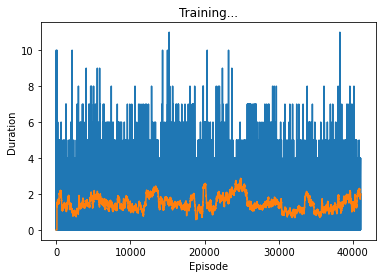

<ipython-input-3-a0050f206e03>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.head(x))


In [ ]:
num_episodes = 1000000
name = "breakout_dqn_v4_"

def custom_get_screen(obvs, device):
    screen = obs.transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return utils.screen_transforms(screen).unsqueeze(0).to(device)

gc.collect()
torch.cuda.empty_cache()

for _ in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    
    for _ in range(HISTORY_LENGTH):
        frames.append(utils.get_screen(env, device))
    state = torch.cat(tuple(frames), 1)
        
    total_reward = 0
    for t in count():
        # Select and perform an action
        action = utils.epsilon_greedy(state, policy_net, steps_done, n_actions, \
                                      device, EPS_START, EPS_END, EPS_DECAY) + 1
        steps_done += 1
        
        # Observe new state
        reward = 0
        for _ in range(SKIP_FRAMES):
            obs, p_reward, done, _ = env.step(action.item())
            
            frames.append(custom_get_screen(obs, device))
            reward += p_reward
            if done:
                break
        total_reward += reward
        reward = torch.tensor([reward], device=device)

        if not done:
            next_state = torch.cat(tuple(frames), 1)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model(policy_net, target_net, optimizer, memory, device, BATCH_SIZE, GAMMA)
        if done:
            durations.append(total_reward)
            #utils.plot_performance(durations)
            break
            
    i_episode += 1
    
    if i_episode % CHART_UPDATE == 0:
        utils.plot_performance(durations)
    
    if i_episode % CHECKPOINT_UPDATE == 0:
        utils.save_checkpoint(policy_net, optimizer, name+str(i_episode), extra={
            "i_episode": i_episode,
            "steps_done": steps_done,
            "durations": durations,
            "memory": memory
        })
        if i_episode > CHECKPOINT_UPDATE*2:
            utils.delete_checkpoint(name+str(i_episode-(CHECKPOINT_UPDATE*2)))
    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

In [ ]:
env.close()